In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [3]:
data = pd.read_csv('train_csv.csv')

In [4]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [8]:
import cv2

In [10]:
!unzip "train_images.zip" -d "train_images"

Archive:  train_images.zip
  inflating: train_images/f00185797.jpg  
  inflating: train_images/f0074b888.jpg  
  inflating: train_images/f0075e43c.jpg  
  inflating: train_images/f024c4789.jpg  
  inflating: train_images/f03379160.jpg  
  inflating: train_images/f0344b3ad.jpg  
  inflating: train_images/f035b1e71.jpg  
  inflating: train_images/f0437a9c3.jpg  
  inflating: train_images/f046dc5fa.jpg  
  inflating: train_images/f061c7c53.jpg  
  inflating: train_images/f0625054e.jpg  
  inflating: train_images/f07399cf6.jpg  
  inflating: train_images/f07969848.jpg  
  inflating: train_images/f0859ea87.jpg  
  inflating: train_images/f08716423.jpg  
  inflating: train_images/f10768627.jpg  
  inflating: train_images/f10e66f64.jpg  
  inflating: train_images/f10f625fd.jpg  
  inflating: train_images/f1119e073.jpg  
  inflating: train_images/f11471db2.jpg  
  inflating: train_images/f114d1a28.jpg  
  inflating: train_images/f11d59e33.jpg  
  inflating: train_images/f12206185.jpg  
  infla

In [114]:
l1=[]
l2=[]
l3=[]
l4=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(1600,256))
      l1.append(image)
      l2.append(ClassId)
      l3.append(EncodedPixels)
      l4.append(img)
    except:
      continue

100%|██████████| 7095/7095 [00:04<00:00, 1678.04it/s]


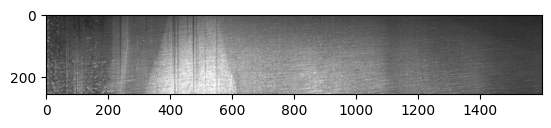

In [56]:
i = 15
plt.imshow(l1[i])

In [47]:
len(l3)

351

In [39]:
from collections import Counter

In [41]:
c = Counter(l2)
c

Counter({3: 246, 1: 55, 4: 31, 2: 19})

In [44]:
l3

['348614 43 348828 86 349085 85 349342 85 349599 85 349856 85 350113 84 350370 84 350627 83 350884 81 351141 80 351398 79 351658 75 351921 67 352181 63 352438 62 352695 61 352952 60 353209 58 353466 57 353723 56 353979 55 354236 53 354493 51 354750 49 355007 48 355264 46 355521 44 355778 42 356042 33 356310 18 356574 6',
 '39678 3 39928 9 40178 15 40428 21 40678 27 40931 30 41187 30 41442 31 41698 31 41953 32 42209 32 42464 33 42720 33 42975 34 43231 34 43486 35 43742 35 43997 36 44253 36 44377 3 44508 37 44632 9 44764 37 44888 14 45020 37 45143 20 45275 38 45398 26 45531 38 45654 29 45786 39 45909 30 46042 39 46164 32 46297 40 46420 32 46553 40 46675 33 46808 41 46930 35 47064 41 47186 35 47319 42 47441 36 47575 42 47697 36 47830 43 47952 38 48086 43 48207 39 48341 44 48463 39 48597 44 48718 41 48857 40 48973 42 49119 34 49229 42 49378 31 49484 44 49636 29 49739 45 49894 27 49995 45 50152 25 50250 47 50410 23 50506 47 50667 22 50762 47 50925 20 51019 47 51183 18 51275 47 51441 16 5153

In [71]:
from sklearn.model_selection import train_test_split
train_data, cv_data = train_test_split(data, test_size=0.15, random_state=42)
print(train_data.shape)
print(cv_data.shape)

(6030, 3)
(1065, 3)


In [116]:
def rle2mask_test(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]

    mask= np.zeros( width*height ).astype(np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )


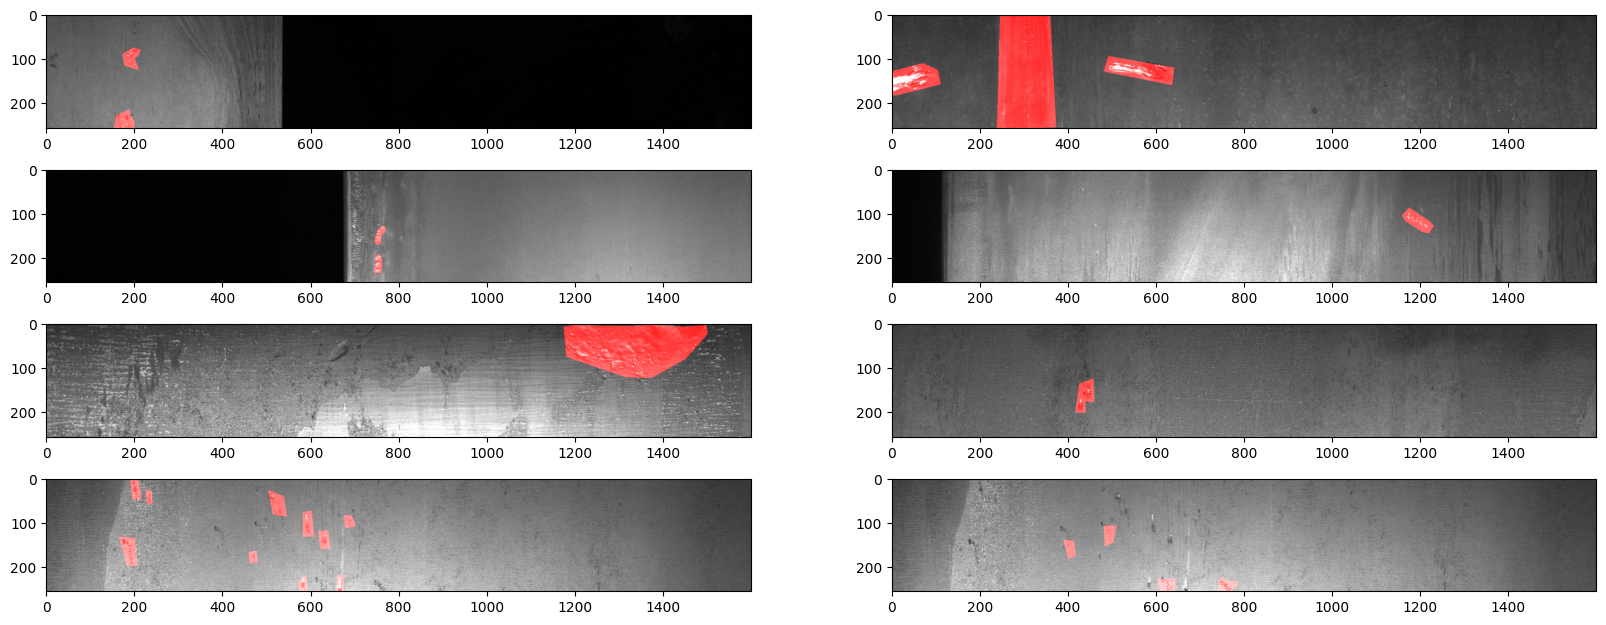

In [117]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
for i in range(1, 9):
    fig.add_subplot(rows, columns, i)
    img = l1[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask_test( l3[i], img.shape  )
    img[mask==1,0] = 255

    plt.imshow(img)
plt.show()

In [118]:
def rle2mask(rle):
    # CONVERT RLE TO MASK
    if (pd.isnull(rle))|(rle==''):
        return np.zeros((256,1600) ,dtype=np.uint8)

    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1

    return mask.reshape( (height,width), order='F' )[::2,::2]


# чтобы преобразовать маски в значения, закодированные по длине выполнения
def mask2rle(img):
    '''
    изображение: массив numpy, содержащий единицы и нули в качестве значений в пикселях, 1 - маска, 0 - фон
    Возвращает длину строки, закодированную в пикселях
    '''
    pixels= img.T.flatten() # Convert nd-array to 1d-array (numbering of pixels is from top to bottom)
    pixels = np.concatenate([[0], pixels, [0]]) # Adding zeros at the start and end so that if there's mask at the first/last pixel, it gets detected.
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 # Detect all changing pixels (where pixel values changes, either 0 -> 1 or 1 -> 0)

    # Чтобы получить RLE, нам нужны начальные пиксели и длина пробега
    # Начальные пиксели - это пиксели, в которых происходит изменение 0 -> 1, т.е. пиксели с четными индексами
    # Длина пробега - это расстояние в пикселях между двумя последовательно изменяющимися пикселями. Итак, длина пробега = нечетные индексы - четные индексы
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

In [100]:
data.shape[1]

3

In [102]:
len(l4)

351

In [120]:
indices = l1.index
y = np.empty((len(l4), 128, 800, 4), dtype=np.uint8)
for i, f in enumerate(l4):
    f = f.split('.')[0]
    #run-length encoding on the pixel values
    for j in range(4):
        y[i,:,:,j] = rle2mask(l3[i])
        cv2.imwrite(f'train_masks/{f}_mask{j+1}.png', y[i,:,:,j])

In [121]:
train_ids = train_data['ImageId'].values
train_image_paths = ['train_images/'+i for i in train_ids]

train_label_paths = [['train_masks/'+i.split('.')[0]+'_mask1.png',
                     'train_masks/'+i.split('.')[0]+'_mask2.png',
                     'train_masks/'+i.split('.')[0]+'_mask3.png',
                     'train_masks/'+i.split('.')[0]+'_mask4.png'] for i in train_ids]

In [122]:
val_ids = cv_data['ImageId'].values
val_image_paths = ['train_images/'+i for i in val_ids]

val_label_paths = [['train_masks/'+i.split('.')[0]+'_mask1.png',
                     'train_masks/'+i.split('.')[0]+'_mask2.png',
                     'train_masks/'+i.split('.')[0]+'_mask3.png',
                     'train_masks/'+i.split('.')[0]+'_mask4.png'] for i in val_ids]

In [123]:
tf.random.set_seed(42)
def tfdata_generator(images, labels, is_training, batch_size=16):
    '''Construct a data generator using tf.Dataset'''

    def parse_function(filename, labels):

        #reading image
        image_string = tf.io.read_file(filename) # read as string of pixel values
        image = tf.image.decode_jpeg(image_string, channels=3) # decode image as tensor of dtype uint8

        image = tf.image.convert_image_dtype(image, tf.float32) # convert to float values in range [0, 1]
        image = tf.image.resize(image, [128, 800]) #resize to desired size

        #reading label masks
        y = tf.zeros((128,800,1), dtype=tf.uint8)
        for j in range(4):
            mask_string = tf.io.read_file(labels[j])
            mask = tf.image.decode_jpeg(mask_string)
            mask = tf.image.convert_image_dtype(mask, tf.uint8)

            y = tf.concat([y, mask], 2)


        return image, y[:,:,1:]

    def flip(image,labels):

        image = tf.image.random_flip_left_right(image, seed=1)
        labels = tf.image.random_flip_left_right(labels, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        labels = tf.image.random_flip_up_down(labels, seed=1)

        return image, labels

    def color(image,labels):
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.random_saturation(image, 0.4, 1.2)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, 0.4, 1.2)
        return image, labels

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.map(parse_function, num_parallel_calls=4)

    augmentations = [flip, color]

    if is_training:
      for f in augmentations:
        if tf.random.uniform([1], 0, 1)>0.6:
            dataset = dataset.map(f, num_parallel_calls=4)

    # dataset = dataset.repeat()

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [124]:
tf_image_generator = tfdata_generator(train_image_paths, train_label_paths, is_training=True, batch_size=8)

In [125]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

def  dice_loss(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

In [126]:
import tensorflow as tf
from tensorflow.keras import backend as K

# from keras.applications import imagenet_utils
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras import layers, Model
import tensorflow.keras as keras

In [127]:
class Conv2D_custom(layers.Layer):

    ''' args:

            filters: Integer, the number of filters in convolution
            prefix: String, name of the block of which this layer is a part
            stride: Integer, stride for convolution, default=1
            kernel_size: Integer, size of kernel for convolution, default=3
            rate: Integer, atrous rate for convolution, default=1

        Input: 4D tensor with shape (batch, rows, cols, channels)
        Output: 4D tensor with shape (batch, new_rows, new_cols, filters)
    '''

    def __init__(self, filters, prefix='', stride=1, kernel_size=3, rate=1):
        super(Conv2D_custom, self).__init__()

        self.stride = stride
        # manual padding when stride!=1
        if stride!=1:
            #effective kernel size = kernel_size + (kernel_size - 1) * (rate - 1)
            n_pads = (kernel_size + (kernel_size - 1) * (rate - 1) - 1) // 2
            self.zeropad = layers.ZeroPadding2D(padding=n_pads)

        self.conv_2d = layers.Conv2D(filters, kernel_size=kernel_size, strides= stride, dilation_rate=rate,
                            padding='same' if stride==1 else 'valid', name=prefix + 'Conv2D_custom')

    def call(self, x):
        if self.stride != 1:
            x = self.zeropad(x)

        x = self.conv_2d(x)
        return x

In [128]:
class SeparableConv_BN(Model):

    ''' Разделяемые свертки состоят в том, что сначала выполняется пространственная свертка по глубине
(которая воздействует на каждый входной канал отдельно), за которой следует поточечная свертка, которая смешивает результирующие выходные каналы.

- Это пользовательская реализация слоя SeparableConv2D.
- Для использования в encoder (модифицированном блоке Xception) DeepLabV3+.

В чем разница между этой реализацией и tf.keras.layers.SeparableConv2D заключается в том, что
здесь дополнительная пакетная нормализация и ReLU добавляются после каждой свертки по глубине 3×3

аргументы:

фильтры: целое число, количество выходных фильтров в поточечной свертке
префикс: Строка, название блока, частью которого является этот слой
шаг: Целое число, шаг для глубинной свертки, по умолчанию=1
kernel_size: Целое число, размер ядра для свертки по глубине, по умолчанию=3
скорость: Целое число, абсолютная скорость для свертки по глубине, по умолчанию=1
depth_activation: Bool, флаг для использования активации между глубинными и поточечными свертками

Входные данные: 4D-тензор с формой (пакет, строки, столбцы, каналы)
Результат: 4D-тензор с формой (пакет, new_rows, new_cols, фильтры)
    '''

    def __init__(self, filters, prefix='', stride=1, kernel_size=3, rate=1, depth_activation=False):
        super(SeparableConv_BN, self).__init__()

        self.stride = stride
        self.depth_activation = depth_activation
        # manual padding size when stride!=1
        if stride!=1:
            #effective kernel size = kernel_size + (kernel_size - 1) * (rate - 1)
            n_pads = (kernel_size + (kernel_size - 1) * (rate - 1) - 1) // 2
            self.zeropad = layers.ZeroPadding2D(padding=n_pads)

        self.depthwise_conv = layers.DepthwiseConv2D(kernel_size=kernel_size, strides= stride, dilation_rate=rate,
                            padding='same' if stride==1 else 'valid', name=prefix + '_depthW')
        self.batchnorm_d = layers.BatchNormalization(name=prefix + '_depthW_BN')

        self.pointwise_conv = layers.Conv2D(filters, kernel_size=1, padding='same', name=prefix + '_pointW')
        self.batchnorm_p = layers.BatchNormalization(name=prefix + '_pointW_BN')

    def call(self, x):
        if self.stride != 1:
            x = self.zeropad(x)

        if not self.depth_activation:
            x = tf.nn.relu(x)

        x = self.depthwise_conv(x)
        x = self.batchnorm_d(x)
        if self.depth_activation:
            x = tf.nn.relu(x)
        x = self.pointwise_conv(x)
        x = self.batchnorm_p(x)
        if self.depth_activation:
            x = tf.nn.relu(x)

        return x

In [129]:
class Xception_Block(Model):
    ''' Базовый строительный блок сети DeepLabV3+ encoder (модифицированный Xception).
        Она состоит из 3 отдельных слоев CONV_BN.

        аргументы:
        depth_list: список из 3 целых чисел, количество фильтров в каждом отдельном слое CONV_BN.
        префикс: строка, префикс перед названием слоя
        short_path_type: Строка, одна из {'conv','sum'} по умолчанию=Нет; тип быстрого соединения между входом и выходом блока
        шаг: Целое число, шаг для свертки по глубине в последнем (3-м) слое
        скорость: целая, кратная скорость для свертки по глубине
        depth_activation: Bool, флаг для использования активации между глубинными и поточечными свертками
        return_skip: Bool, флаг для возврата дополнительного тензора после 2-х последовательных преобразований для декодера
    '''
    def __init__(self, depth_list, prefix='', residual_type=None, stride=1, rate=1, depth_activation=False, return_skip=False):
        super(Xception_Block, self).__init__()

        self.sepConv1 = SeparableConv_BN(filters=depth_list[0], prefix=prefix +'_sepConv1', stride=1, rate=rate, depth_activation=depth_activation)
        self.sepConv2 = SeparableConv_BN(filters=depth_list[1], prefix=prefix +'_sepConv2', stride=1, rate=rate, depth_activation=depth_activation)
        self.sepConv3 = SeparableConv_BN(filters=depth_list[2], prefix=prefix +'_sepConv3', stride=stride, rate=rate, depth_activation=depth_activation)

        if residual_type == 'conv':
            self.conv2D = Conv2D_custom(depth_list[2], prefix=prefix+'_conv_residual', stride=stride, kernel_size=1, rate=1)
            self.batchnorm_res = layers.BatchNormalization(name=prefix + '_BN_residual')

        self.return_skip = return_skip
        self.residual_type = residual_type

    def call(self, x):
        output = self.sepConv1(x)
        output = self.sepConv2(output)
        skip = output # skip connection to decoder
        output= self.sepConv3(output)

        if self.residual_type == 'conv':
            res = self.conv2D(x)
            res = self.batchnorm_res(res)
            output += res
        elif self.residual_type == 'sum':
            output +=  x
        else:
            if(self.residual_type):
                raise ValueError('Arg residual_type should be one of {conv, sum}')

        if self.return_skip:
            return output, skip

        return output

In [130]:
class DeepLabV3plus(Model):


    def __init__(self, input_size=(512, 512, 3), n_classes=4):
        super(DeepLabV3plus, self).__init__()

        self.n_classes = n_classes
        self.input_size = input_size

        # Encoder block
        self.conv2d1 = layers.Conv2D(32, (3, 3), strides=2, name='entry_conv1', padding='same')
        self.bn1 = layers.BatchNormalization(name='entry_BN')
        self.custom_conv1 = Conv2D_custom(64, kernel_size=3, stride=1, prefix='entry_conv2')
        self.bn2 = layers.BatchNormalization(name='conv2_s1_BN')

        self.entry_xception1 = Xception_Block([128, 128, 128], prefix='entry_x1', residual_type='conv', stride=2, rate=1)
        self.entry_xception2 = Xception_Block([256, 256, 256], prefix='entry_x2', residual_type='conv', stride=2, rate=1, return_skip=True)
        self.entry_xception3 = Xception_Block([728, 728, 728], prefix='entry_x3', residual_type='conv', stride=2, rate=1)

        self.middle_xception = [Xception_Block([728, 728, 728], prefix=f'middle_x{i+1}', residual_type='sum', stride=1, rate=1) for i in range(16)]

        self.exit_xception1 = Xception_Block([728, 1024, 1024], prefix='exit_x1', residual_type='conv', stride=1, rate=1)
        self.exit_xception2 = Xception_Block([1536, 1536, 2048], prefix='exit_x2', residual_type=None, stride=1, rate=2, depth_activation=True)

        # Feature projection
        self.conv_feat = layers.Conv2D(256, (1, 1), padding='same', name='conv_featureProj')
        self.bn_feat = layers.BatchNormalization(name='featureProj_BN')
        self.atrous_conv1 = SeparableConv_BN(filters=256, prefix='aspp1', stride=1, rate=6, depth_activation=True)
        self.atrous_conv2 = SeparableConv_BN(filters=256, prefix='aspp2', stride=1, rate=12, depth_activation=True)
        self.atrous_conv3 = SeparableConv_BN(filters=256, prefix='aspp3', stride=1, rate=18, depth_activation=True)
        self.image_pooling = layers.AveragePooling2D(8)
        self.conv_pool = layers.Conv2D(256, (1, 1), padding='same', name='conv_imgPool')
        self.bn_pool = layers.BatchNormalization(name='imgPool_BN')
        self.concat1 = layers.Concatenate()
        self.encoder_op = layers.Conv2D(256, (1, 1), padding='same', name='conv_encoder_op')
        self.bn_enc = layers.BatchNormalization(name='encoder_op_BN')

        # Decoder block
        self.upsample1 = layers.UpSampling2D(size=4)
        self.conv_low = layers.Conv2D(48, (1, 1), padding='same', name='conv_lowlevel_f')
        self.bn_low = layers.BatchNormalization(name='low_BN')
        self.concat2 = layers.Concatenate()
        self.sepconv_last = SeparableConv_BN(filters=256, prefix='final_sepconv', stride=1, depth_activation=True)

        self.out_conv = layers.Conv2D(self.n_classes, (1, 1), activation='sigmoid', padding='same', name='output_layer')
        self.upsample2 = layers.UpSampling2D(size=4)

    def call(self, inputs):
        #===================#
        #  Encoder Network  #
        #===================#
        # Entry Block
        x = self.conv2d1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.custom_conv1(x)
        x = self.bn2(x)

        x = self.entry_xception1(x)
        x, skip1 = self.entry_xception2(x)
        x = self.entry_xception3(x)

        # Middle Block
        for i in range(16):
            x = self.middle_xception[i](x)

        # Exit Block
        x = self.exit_xception1(x)
        x = self.exit_xception2(x)

        #====================#
        # Feature Projection #
        #====================#

        b0 = self.conv_feat(x)
        b0 = self.bn_feat(b0)
        b0 = tf.nn.relu(b0)

        b1 = self.atrous_conv1(x)
        b2 = self.atrous_conv2(x)
        b3 = self.atrous_conv3(x)

        # Image Pooling
        b4 = self.image_pooling(x)
        b4 = self.conv_pool(b4)
        b4 = self.bn_pool(b4)
        b4 = tf.nn.relu(b4)
        b4 = tf.image.resize(b4, size=[b3.get_shape()[1], b3.get_shape()[2]])


        x = self.concat1([b4, b0, b1, b2, b3])

        x = self.encoder_op(x)
        x = self.bn_enc(x)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, rate=0.1)

        #===================#
        #  Decoder Network  #
        #===================#

        x = self.upsample1(x)

        low_level = self.conv_low(skip1)
        low_level = self.bn_low(low_level)
        low_level = tf.nn.relu(low_level)
        x = self.concat2([x, low_level])

        x = self.sepconv_last(x)

        x = self.out_conv(x)
        x = self.upsample2(x)
        return x

In [139]:
# tf.keras.backend.clear_session()
model = DeepLabV3plus(input_size=(256, 1600,3))

In [140]:
batch_size = 16

train_batches = tfdata_generator(train_image_paths, train_label_paths, is_training=True, batch_size=batch_size)
valid_batches = tfdata_generator(val_image_paths, val_label_paths, is_training=False, batch_size=batch_size)

In [141]:
_ = model(train_batches.__iter__().get_next()[0])

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} train_masks/feebe80d4_mask4.png; No such file or directory
	 [[{{node ReadFile_4}}]] [Op:IteratorGetNext] name: 

Здесь возникает ошибка, которая требует дальнейшего изучения. Мы ограничены во времени, потому вернемся к тематике GAN и напишем простую нейросеть на подобной архитектуре.

In [150]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [143]:
# Генерация GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0elt64l1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0elt64l1
  Resolved https://github.com/tensorflow/docs to commit e520630d1505d122c4e1fb0e266eff1976f5b7dc
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.4.23.84782-py3-none-any.whl size=182536 sha256=4f3857e410b1fd4dd1d99e07b0c676bdac50e945e2aa8b74e83d06fca8af58e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-an3pqn12/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [145]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [147]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Нормализация изображения [-1, 1]

In [148]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [149]:
# Пакетная обработка и перемешивание данных
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Генератор использует слои tf.keras.layers.Conv2DTranspose (повышающая дискретизация) для создания изображения из начального числа (случайный шум). Начните со слоя «Dense», который принимает это начальное значение в качестве входных данных, затем несколько раз повышайте дискретизацию, пока не достигнете желаемого размера изображения 28x28x1. Обратите внимание на активацию tf.keras.layers.LeakyReLU для каждого слоя, кроме выходного слоя, который использует tanh.

In [151]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

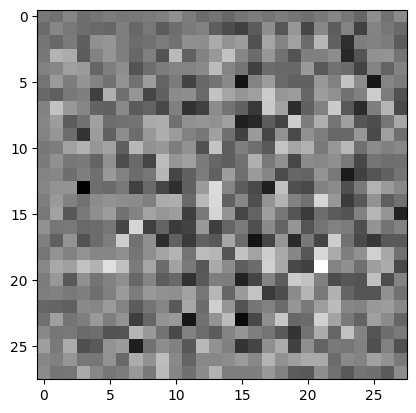

In [152]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [153]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Используйте дискриминатор (пока еще необученный), чтобы классифицировать сгенерированные изображения как настоящие или поддельные. Модель будет обучена выводить положительные значения для реальных изображений и отрицательные значения для поддельных изображений.

In [154]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00153666]], shape=(1, 1), dtype=float32)


In [155]:
# Этот метод возвращает вспомогательную функцию для вычисления потерь перекрестной энтропии.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Потеря дискриминатора
Этот метод количественно определяет, насколько хорошо дискриминатор способен отличать настоящие изображения от подделок. Он сравнивает прогнозы дискриминатора для реальных изображений с массивом единиц, а прогнозы дискриминатора для поддельных (сгенерированных) изображений — с массивом нулей.

In [156]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Потеря генератора
Потери генератора количественно определяют, насколько хорошо ему удалось обмануть дискриминатор. Интуитивно понятно, что если генератор работает хорошо, дискриминатор классифицирует поддельные изображения как настоящие (или 1). Здесь сравните решения дискриминатора по сгенерированным изображениям с массивом единиц.

In [157]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [158]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Сохранение контрольных точек
В этом блокноте также показано, как сохранять и восстанавливать модели, что может оказаться полезным в случае прерывания длительной задачи обучения.

In [159]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [160]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Вы будете повторно использовать это начальное значение(так будет проще)
# для визуализации прогресса в анимированном GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Цикл обучения начинается с того, что генератор получает на вход случайное начальное число. Это семя используется для создания изображения. Затем дискриминатор используется для классификации реальных изображений (взятых из обучающего набора) и поддельных изображений (созданных генератором). Потери рассчитываются для каждой из этих моделей, а градиенты используются для обновления генератора и дискриминатора.

In [161]:
# Обратите внимание на использование `tf.function`
# Эта аннотация приводит к «компиляции» функции.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [162]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Создавайте изображения для GIF по ходу обучения
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Сохранить модель каждые 15 эпох
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Генерация финальной эпохи
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Создание и сохранение изображений

In [163]:
def generate_and_save_images(model, epoch, test_input):
    # Обратите внимание: для параметра «training» установлено значение False.
    # Это значит, что все слои работают в режиме вывода (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Вызовите метод train(), определенный выше, для одновременного обучения генератора и дискриминатора. Обратите внимание: обучение GAN может оказаться непростой задачей. Важно, чтобы генератор и дискриминатор не подавляли друг друга (например, чтобы они обучались с одинаковой скоростью).

В начале обучения сгенерированные изображения выглядят как случайный шум. По мере обучения сгенерированные цифры будут выглядеть все более реальными. Примерно через 50 эпох они напоминают цифры MNIST. Это может занять около одной минуты/эпохи при настройках Colab по умолчанию.

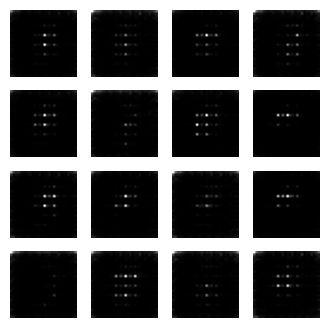

Time for epoch 2 is 663.9079751968384 sec


KeyboardInterrupt: 

In [164]:
train(train_dataset, EPOCHS)

In [165]:
# Восстановите последнюю контрольную точку.

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [166]:
# Отобразите одно изображение, используя номер эпохи
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [167]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

In [168]:
# Используйте imageio, чтобы создать анимированный GIF-изображение, используя изображения, сохраненные во время обучения.

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-168-eb4024fa66fc>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-168-eb4024fa66fc>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



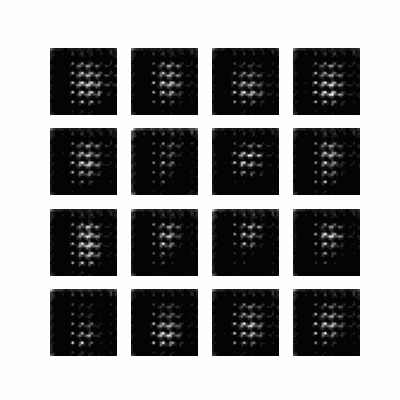

In [169]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

На лекциях мы познакомились с базовыми моделями генеративных нейросетей на примере вариационного автоэнкодера(VAE) и генеративно-состязательный нейросетей Vanilla GAN, CycleGAN и StyleGAN.
Рассмотрим еще несколько архитектур из этого класса.

### text-2-image

Генеративно-состязательные сети хорошо генерируют случайные изображения. Например, GAN, обученный на изображениях кошек, может генерировать случайные изображения кошки с двумя глазами, двумя ушами и усами. Но цветовой рисунок на кошке может быть очень случайным. Таким образом, случайные изображения часто бесполезны для решения бизнес-задач. Теперь попросить GAN сгенерировать изображение на основе наших ожиданий — чрезвычайно сложная задача.

Текстовое описание преобразуется в 256-мерное вложение и объединено со 100-мерным вектором шума [который был выбран из скрытого пространства, которое обычно представляет собой случайное нормальное распределение].

Эта формулировка поможет генератору генерировать изображения, соответствующие входному описанию, вместо генерации случайных изображений.

Для дискриминатора вместо единственного изображения в качестве входных данных отправляется пара изображений и встраивания текста. Выходные сигналы имеют значение 0 или 1. Раньше обязанностью Дискриминатора было просто предсказать, является ли данное изображение реальным или поддельным.

Теперь у Дискриминатора есть еще одна дополнительная обязанность. Наряду с определением того, является ли данное изображение прочитанным или поддельным, оно также прогнозирует вероятность того, совпадают ли данное изображение и текст друг с другом.

Эта формулировка заставляет Генератор не только генерировать изображения, которые выглядят реальными, но также генерировать изображения, соответствующие входному текстовому описанию.

Чтобы выполнить двойную ответственность Дискриминатора, во время обучения в качестве входных данных модели подается ряд различных пар (изображение, текст), а именно:

Пара (Real Image, Real Caption) в качестве входной и целевой переменной имеет значение 1.
Пара (неправильное изображение, реальная подпись) в качестве входной и целевой переменной имеет значение 0.
Пара (поддельное изображение, реальная подпись) в качестве входной и целевой переменной имеет значение 0.
Пара Real Image и Real Caption задается для того, чтобы модель узнала, совпадают ли данная пара изображения и текста друг с другом. Неправильное изображение, прочтите подпись означает, что изображение не соответствует описанию в подписи. В этом случае целевой переменной присваивается значение 0, чтобы модель узнала, что данное изображение и подпись не совпадают. Здесь поддельное изображение означает изображение, сгенерированное генератором, в этом случае целевая переменная установлена ​​в 0, чтобы модель дискриминатора могла различать настоящие и поддельные изображения.

Использованная литература:

Исследовательский документ: https://arxiv.org/pdf/1605.05396.pdf.

Github: https://github.com/paarthneekhara/text-to-image


### DiscoGAN

В последнее время DiscoGAN стал очень популярным благодаря своей способности изучать междоменные отношения на основе неконтролируемых данных.

Для людей междоменные отношения очень естественны. Имея изображения двух разных доменов, человек может понять, как они связаны друг с другом. Например, на следующем рисунке у нас есть изображения из двух разных областей, и, взглянув на эти изображения, мы можем очень легко понять, что они связаны по природе своего внешнего цвета.

Теперь построение модели машинного обучения для определения такой связи с учетом непарных изображений из двух разных доменов является чрезвычайно сложной задачей.

В последнее время DiscoGAN показал многообещающие результаты в изучении такой связи в двух разных областях.

Основная концепция DiscoGAN очень похожа на CycleGAN:

Оба изучают две отдельные функции преобразования: один изучает преобразование из домена X в домен Y, тогда как другой изучает обратное сопоставление, и оба используют потери при реконструкции как меру того, насколько хорошо восстанавливается исходное изображение после двойного преобразования между доменами.
Оба следуют принципу: если мы преобразуем изображение из одного домена1 в домен2, а затем снова обратно в домен1, то оно должно соответствовать исходному изображению.
Основное различие между DiscoGAN и CycleGAN заключается в том, что DiscoGAN использует две потери реконструкции, по одной для обоих доменов, тогда как CycleGAN использует потерю согласованности за один цикл.

Как и CycleGAN, DiscoGAN также построен на принципе потерь при реконструкции. Идея состоит в том, что когда изображение преобразуется из одного домена в другой, а затем обратно в исходный домен, сгенерированное изображение должно быть максимально близко к исходному. В этом случае количественная разница рассматривается как потеря реконструкции, и во время обучения модель пытается минимизировать эту потерю.

Итак, модель состоит из двух сетей GAN, называемых GAB и GBA. На рисунке выше модель пытается изучить междоменные отношения с точки зрения их направления. После реконструкции изображения направление должно быть таким же, как и исходное.

Использованная литература :

Исследовательский документ : https://arxiv.org/pdf/1703.05192.pdf.

Гитхаб : https://github.com/SKTBrain/DiscoGAN

### Выводы.

НА этом курсе мы познакомились с базовыми архитектурами нейросетей различных классов, изучили несколько фреймворков упрощающих работу по созданию и обучению нейросетей.

Даже используя фреймфорки которые избавляют от сложной математики все равно остается масса параметров требующих дальнейшего изучения.
Нужно достаточно точно понимать задачу и изучать имеющийся датасет чтобы выбрать оптимальную архитектуру нейросети, наиболее эффективно справляющуюся с поставленной задачей. Разделять задачи классификации и регрессии, выбор подходяего оптимизатора и функции минимизации ошибки.

Однако есть ряд высоких требований к вычислительным мощностям. Для рассмотренной в этом блоке задачи GAN для генерации простых рукописных чисел потребовалось огромное время сопоставимое с реальными производственными задачами.
Обучение даже двух эпох заняло более 20 минут.

Time for epoch 2 is 663.9079751968384 sec

А для достижения более приемлемого результата требуется не менее 50 эпох обучения.

Эта же проблема касается и задач детектирования и сегментации ,если у нас имеется тяжелый датасет промышленных данных.

Наиболее перспективным с точки зрения затрат ресурсов и полученным результатом выглядят нейросети с полносвязными слоями для классификации и кластеризации данных. При относительно быстрой работе достигается хороший результат для разработки статистических моделей.

Так же подобные архитектры и сети долгой краткосрочной памяти(LSTM) справляются с сложными языковыми моделями, что так же имеет множество практических применений в чат ботах и голосовых помошниках.

Наибольшей же перспективой обладают нейросети детектирования. Сфера их применения всеобъемлюща от систем безопасности и автопилота, до автоматизации практически любых процессов доступных человеку. Однако именно эти задачи из-за объема и сложности данных самые ресурсозатратные и к сожалению их изучение крайне ограничено для обычных пользователей.


